## Deep Learning

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
import gc
import itertools

import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
# TODO: [ilias] data augmentation

In [3]:
print(tf.__version__)

2.8.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


### Data Loading

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [10]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Hyperparameter Tuning

In [11]:
SEED = 123456

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [28]:
def cnn_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=hp.Int("1st-filter", min_value=32, max_value=128, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(28, 28, 1),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("1st-dropout", min_value=0.0, max_value=0.6, step=0.1),
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=hp.Int("2nd-filter", min_value=32, max_value=64, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("2nd-dropout", min_value=0.0, max_value=0.6, step=0.1),
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=hp.Int("dense-layer-units", min_value=32, max_value=128, step=16),
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=10, activation="softmax", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice(
                "learning-rate", values=[1e-3, 1e-4, 2 * 1e-4, 4 * 1e-4]
            )
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model

In [17]:
# BayesianOptimization tuning with Gaussian process
# THERE IS A BUG HERE: https://github.com/keras-team/keras-tuner/pull/655 

# tuner = kt.BayesianOptimization(
#     cnn_model_builder,
#     objective="val_accuracy",
#     max_trials=5,  # the total number of trials (model configurations) to test at most
#     allow_new_entries=True,
#     tune_new_entries=True,
#     seed=SEED,
#     directory="hparam-tuning",
#     project_name="cnn",
# )

In [29]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    cnn_model_builder,
    objective="val_accuracy",
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="cnn",
)

In [48]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
1st-filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
1st-dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.1, 'sampling': None}
2nd-filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': None}
2nd-dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.1, 'sampling': None}
dense-layer-units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
learning-rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 0.0002, 0.0004], 'ordered': True}


In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [31]:
tuner.search(
    train_images, train_labels, epochs=40, validation_split=0.2, callbacks=[stop_early]
)

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of output filters in the 1st convolution : {best_hps.get('1st-filter')}
|
---- optimal first dropout rate                              : {best_hps.get('1st-dropout')}
|
---- optimal number of output filters in the 2nd convolution : {best_hps.get('2nd-filter')}
|
---- optimal second dropout rate                             : {best_hps.get('2nd-dropout')}
|
---- optimal number of units in the densely-connected layer  : {best_hps.get('dense-layer-units')}
|
---- optimal learning rate for the optimizer                 : {best_hps.get('learning-rate')}
"""
)

Trial 90 Complete [00h 12m 08s]
val_accuracy: 0.9087499976158142

Best val_accuracy So Far: 0.9263333082199097
Total elapsed time: 10h 13m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 


Results
|
---- optimal number of output filters in the 1st convolution : 128
|
---- optimal first dropout rate                              : 0.2
|
---- optimal number of output filters in the 2nd convolution : 64
|
---- optimal second dropout rate                             : 0.30000000000000004
|
---- optimal number of units in the densely-connected layer  : 96
|
---- optimal learning rate for the optimizer                 : 0.0002



### Model Selection

In [32]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 28, 28, 128)       1280      
                                                                 
 1st-max-pooling (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 14, 14, 128)       0         
                                                                 
 2nd-convolution (Conv2D)    (None, 14, 14, 64)        73792     
                                                                 
 2nd-max-pooling (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 2nd-dropout (Dropout)       (None, 7, 7, 64)          0

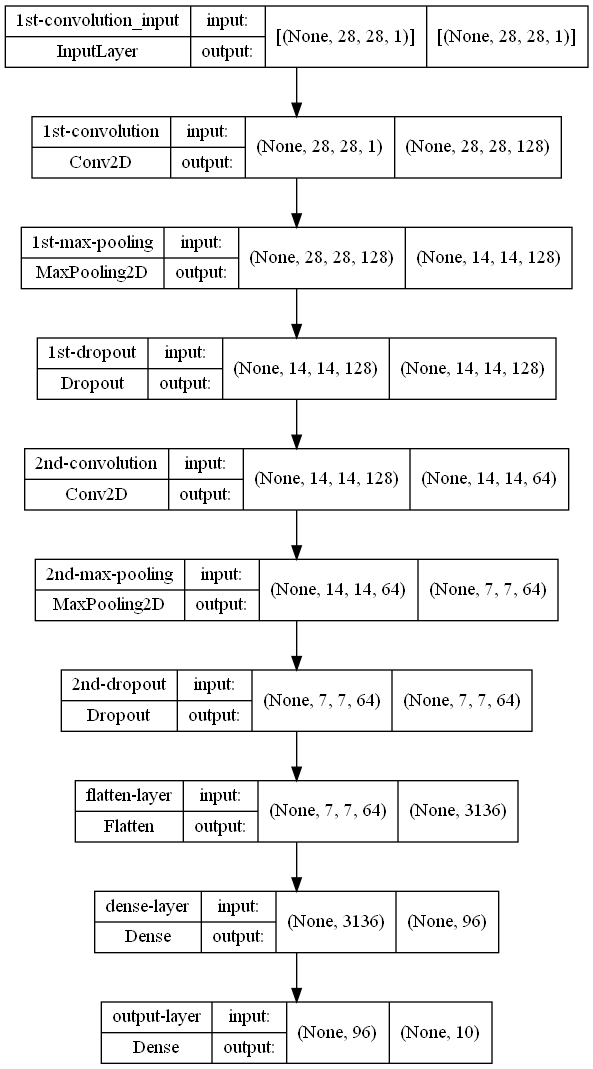

In [33]:
tf.keras.utils.plot_model(
    model, to_file="static/cnn_model.png", show_shapes=True, show_layer_names=True
)

In [36]:
clean_up(model)

In [38]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_split=0.2)

# keep best epoch
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 101s 67ms/step - loss: 0.9329 - accuracy: 0.7323 - val_loss: 0.4477 - val_accuracy: 0.8442
Epoch 2/50
1500/1500 [==============================] - 103s 69ms/step - loss: 0.4390 - accuracy: 0.8404 - val_loss: 0.3665 - val_accuracy: 0.8667
Epoch 3/50
1500/1500 [==============================] - 104s 69ms/step - loss: 0.3615 - accuracy: 0.8676 - val_loss: 0.3218 - val_accuracy: 0.8829
Epoch 4/50
1500/1500 [==============================] - 103s 69ms/step - loss: 0.3128 - accuracy: 0.8846 - val_loss: 0.2903 - val_accuracy: 0.8939
Epoch 5/50
1500/1500 [==============================] - 104s 69ms/step - loss: 0.2871 - accuracy: 0.8935 - val_loss: 0.2703 - val_accuracy: 0.9005
Epoch 6/50
1500/1500 [==============================] - 104s 70ms/step - loss: 0.2625 - accuracy: 0.9028 - val_loss: 0.2483 - val_accuracy: 0.9081
Epoch 7/50
1500/1500 [==============================] - 100s 67ms/step - loss: 0.2429 - accuracy: 0.9097 - val_loss: 0

In [39]:
clean_up(model)

In [40]:
hypermodel = tuner.hypermodel.build(best_hps)

# retrain the model
history = hypermodel.fit(
    train_images, train_labels, epochs=best_epoch, validation_split=0.2
)

Epoch 1/19
1500/1500 [==============================] - 135s 89ms/step - loss: 0.9005 - accuracy: 0.7516 - val_loss: 0.4157 - val_accuracy: 0.8572
Epoch 2/19
1500/1500 [==============================] - 130s 86ms/step - loss: 0.4155 - accuracy: 0.8480 - val_loss: 0.3351 - val_accuracy: 0.8811
Epoch 3/19
1500/1500 [==============================] - 129s 86ms/step - loss: 0.3448 - accuracy: 0.8751 - val_loss: 0.3026 - val_accuracy: 0.8885
Epoch 4/19
1500/1500 [==============================] - 130s 86ms/step - loss: 0.3042 - accuracy: 0.8882 - val_loss: 0.2732 - val_accuracy: 0.9001
Epoch 5/19
1500/1500 [==============================] - 125s 83ms/step - loss: 0.2798 - accuracy: 0.8979 - val_loss: 0.2557 - val_accuracy: 0.9056
Epoch 6/19
1500/1500 [==============================] - 129s 86ms/step - loss: 0.2575 - accuracy: 0.9049 - val_loss: 0.2428 - val_accuracy: 0.9103
Epoch 7/19
1500/1500 [==============================] - 136s 91ms/step - loss: 0.2393 - accuracy: 0.9119 - val_loss: 0

### Evaluation

In [41]:
eval_result = hypermodel.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.2508048415184021, 0.921500027179718]


In [42]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use("dark_background")
    plt.rcParams["figure.figsize"] = [15, 8]
    plt.rcParams["font.size"] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            hs[label].history[metric],
            label="{0:s} train {1:s}".format(label, metric),
            linewidth=2,
        )
        plt.plot(
            hs[label].history["val_{0:s}".format(metric)],
            label="{0:s} validation {1:s}".format(label, metric),
            linewidth=2,
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss" if metric == "loss" else "Accuracy")
    plt.legend()
    plt.show()

Train Loss          : 0.13014
Validation Loss     : 0.23010
Test Loss           : 0.25080
-------------------
Train Accuracy      : 0.95083
Validation Accuracy : 0.92417
Test Accuracy       : 0.92150



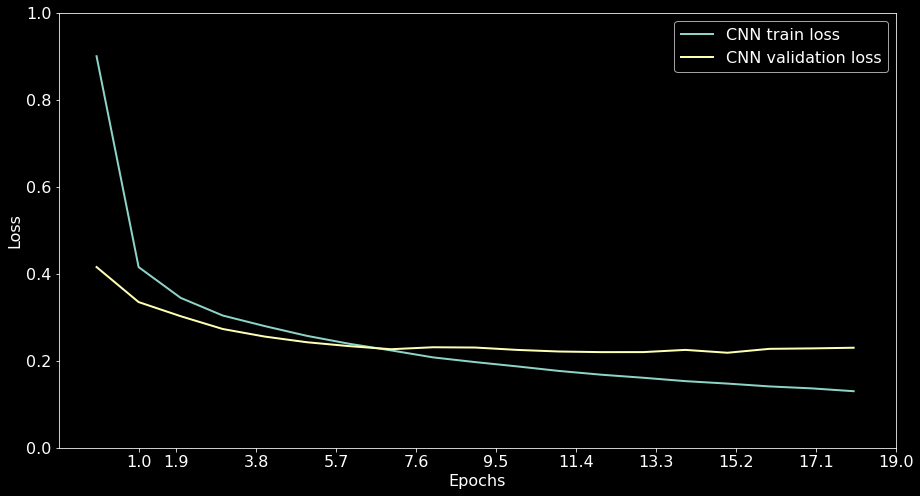

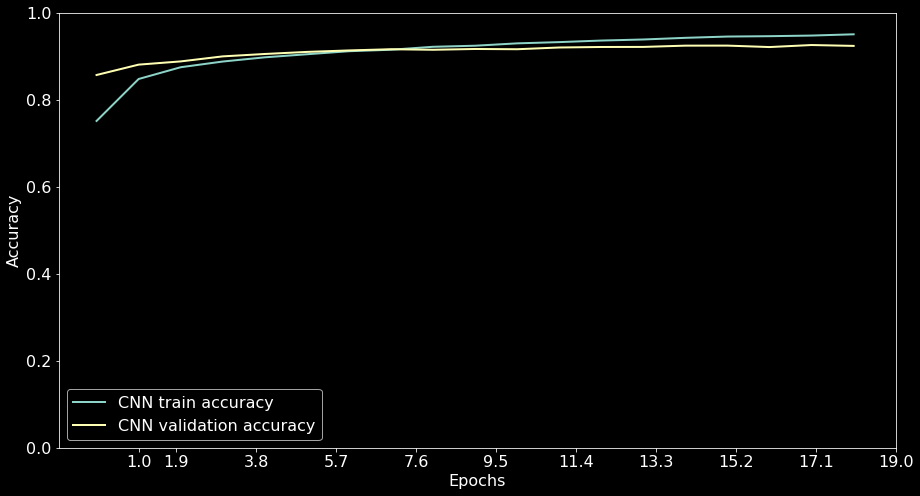

In [43]:
print("Train Loss          : {0:.5f}".format(history.history["loss"][-1]))
print("Validation Loss     : {0:.5f}".format(history.history["val_loss"][-1]))
print("Test Loss           : {0:.5f}".format(eval_result[0]))
print("-------------------")
print("Train Accuracy      : {0:.5f}".format(history.history["accuracy"][-1]))
print("Validation Accuracy : {0:.5f}".format(history.history["val_accuracy"][-1]))
print("Test Accuracy       : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={"CNN": history}, epochs=best_epoch, metric="loss")
plot_history(hs={"CNN": history}, epochs=best_epoch, metric="accuracy")

In [44]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

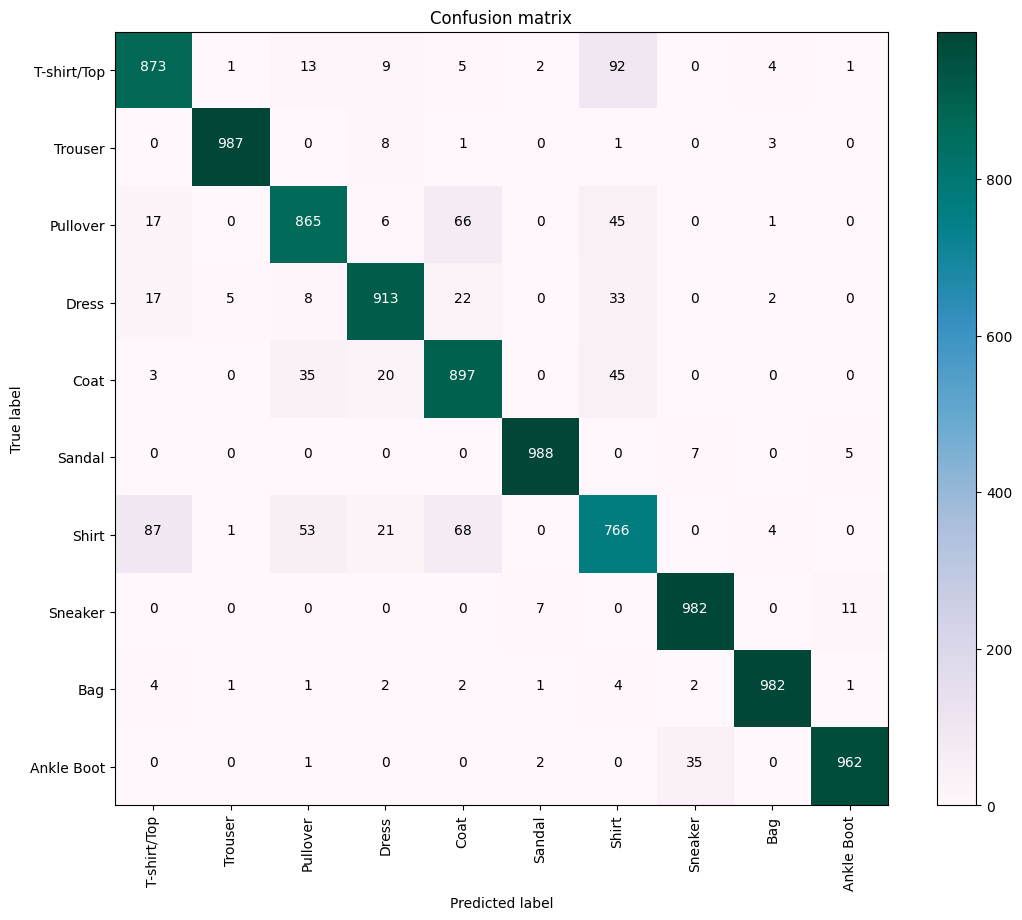

In [45]:
# Predict the values from the validation dataset
Y_pred = hypermodel.predict(test_images)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(
    confusion_mtx,
    classes=class_names,
)

In [46]:
incorrect = []
for i in range(len(test_labels)):
    if not Y_pred_classes[i] == test_labels[i]:
        incorrect.append(i)
    if len(incorrect) == 4:
        break

Text(0.5, 1.0, 'Predicted Label : Shirt\nActual Label : Dress')

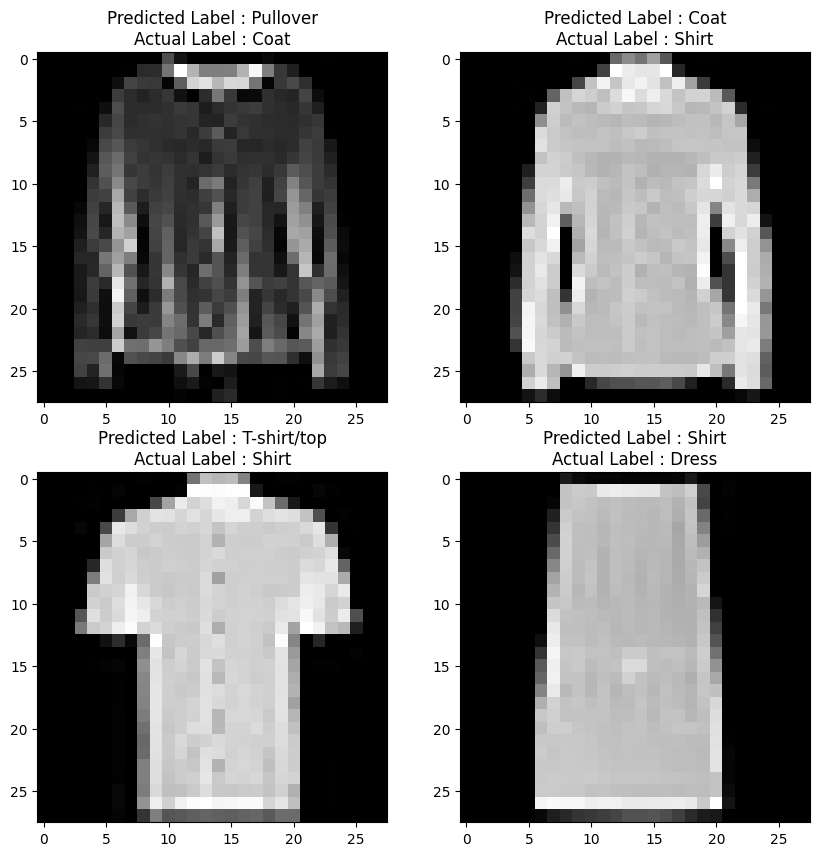

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(test_images[incorrect[0]].reshape(28, 28), cmap="gray")

ax[0, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[0]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[0]]]
)
ax[0, 1].imshow(test_images[incorrect[1]].reshape(28, 28), cmap="gray")
ax[0, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[1]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[1]]]
)
ax[1, 0].imshow(test_images[incorrect[2]].reshape(28, 28), cmap="gray")
ax[1, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[2]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[2]]]
)
ax[1, 1].imshow(test_images[incorrect[3]].reshape(28, 28), cmap="gray")
ax[1, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[3]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[3]]]
)